# (b) Data preparation
(b) (i.)
The are several data imputation techniques.  1. Mean imputation
Simply calculate the mean of the observed values for that variable for all individuals who are non-missing.
It has the advantage of keeping the same mean and the same sample size, but it has many disadvantages. Here we use mean imputation for this task.
We can also use median imputation.

2.Regression imputation
The predicted value obtained by regressing the missing variable on other variables.
So instead of just taking the mean, you’re taking the predicted value based on other variables. This preserves relationships among variables involved in the imputation model.

3.Hot deck imputation
A randomly chosen value from an individual in the sample who has similar values on other variables.
In other words, find all the sample subjects who are similar on other variables, then randomly choose one of their values on the missing variable.
One advantage is you are constrained to only possible values. Another is the random component, which adds in some variability. This is important for accurate standard errors.

(b)(iv.)
From the scatterplots and boxplots, we can see that there exists some outliers which are extremely far away from the other observations. The selected features are not significant since they don’t have linear relationship between each other.

Due to these extremely large outliers, we cannot see the entire boxes in the boxplots as they are compressed.

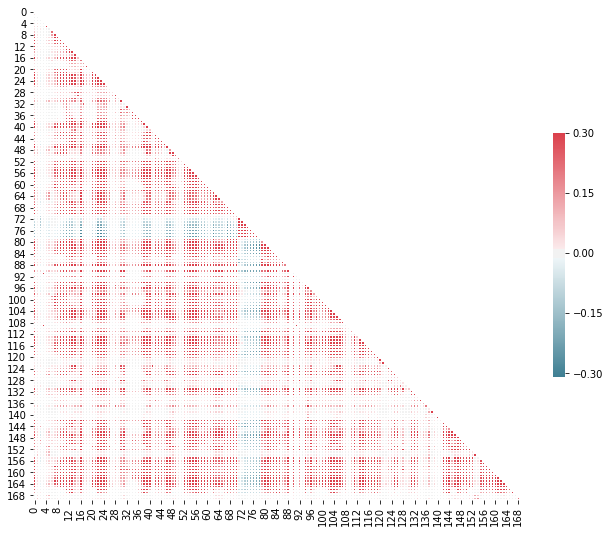

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
import seaborn as sns

train_set =  pd.read_csv('aps_failure_training_set.csv', skiprows=20)
test_set = pd.read_csv('aps_failure_test_set.csv', skiprows=20)
train_data = train_set.iloc[:,1:]
train_label = train_set.iloc[:,0]
test_data = test_set.iloc[:,1:]
test_label = test_set.iloc[:,0]

# i. deal with missing values using mean imputation
train_data = train_data.replace('na', np.NaN)
column = train_data.columns
train_data.columns = range(train_data.shape[1])
train_data = pd.DataFrame(Imputer(missing_values=np.NaN, strategy='mean', axis=0).fit_transform(train_data.values))
train_data.columns = column

test_data = test_data.replace('na', np.NaN)
column = test_data.columns
test_data.columns = range(test_data.shape[1])
test_data = pd.DataFrame(Imputer(missing_values=np.NaN, strategy='mean', axis=0).fit_transform(test_data.values))
test_data.columns = column

# ii. calculate the coefficient of variation for each feature
features = pd.concat([train_data, test_data])
features.columns = range(features.shape[1])
mean=features.mean(axis=0).to_frame()
std = features.std(axis=0).to_frame()
cv = std / mean

# iii. Plot a correlation matrix for features
corr = features.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

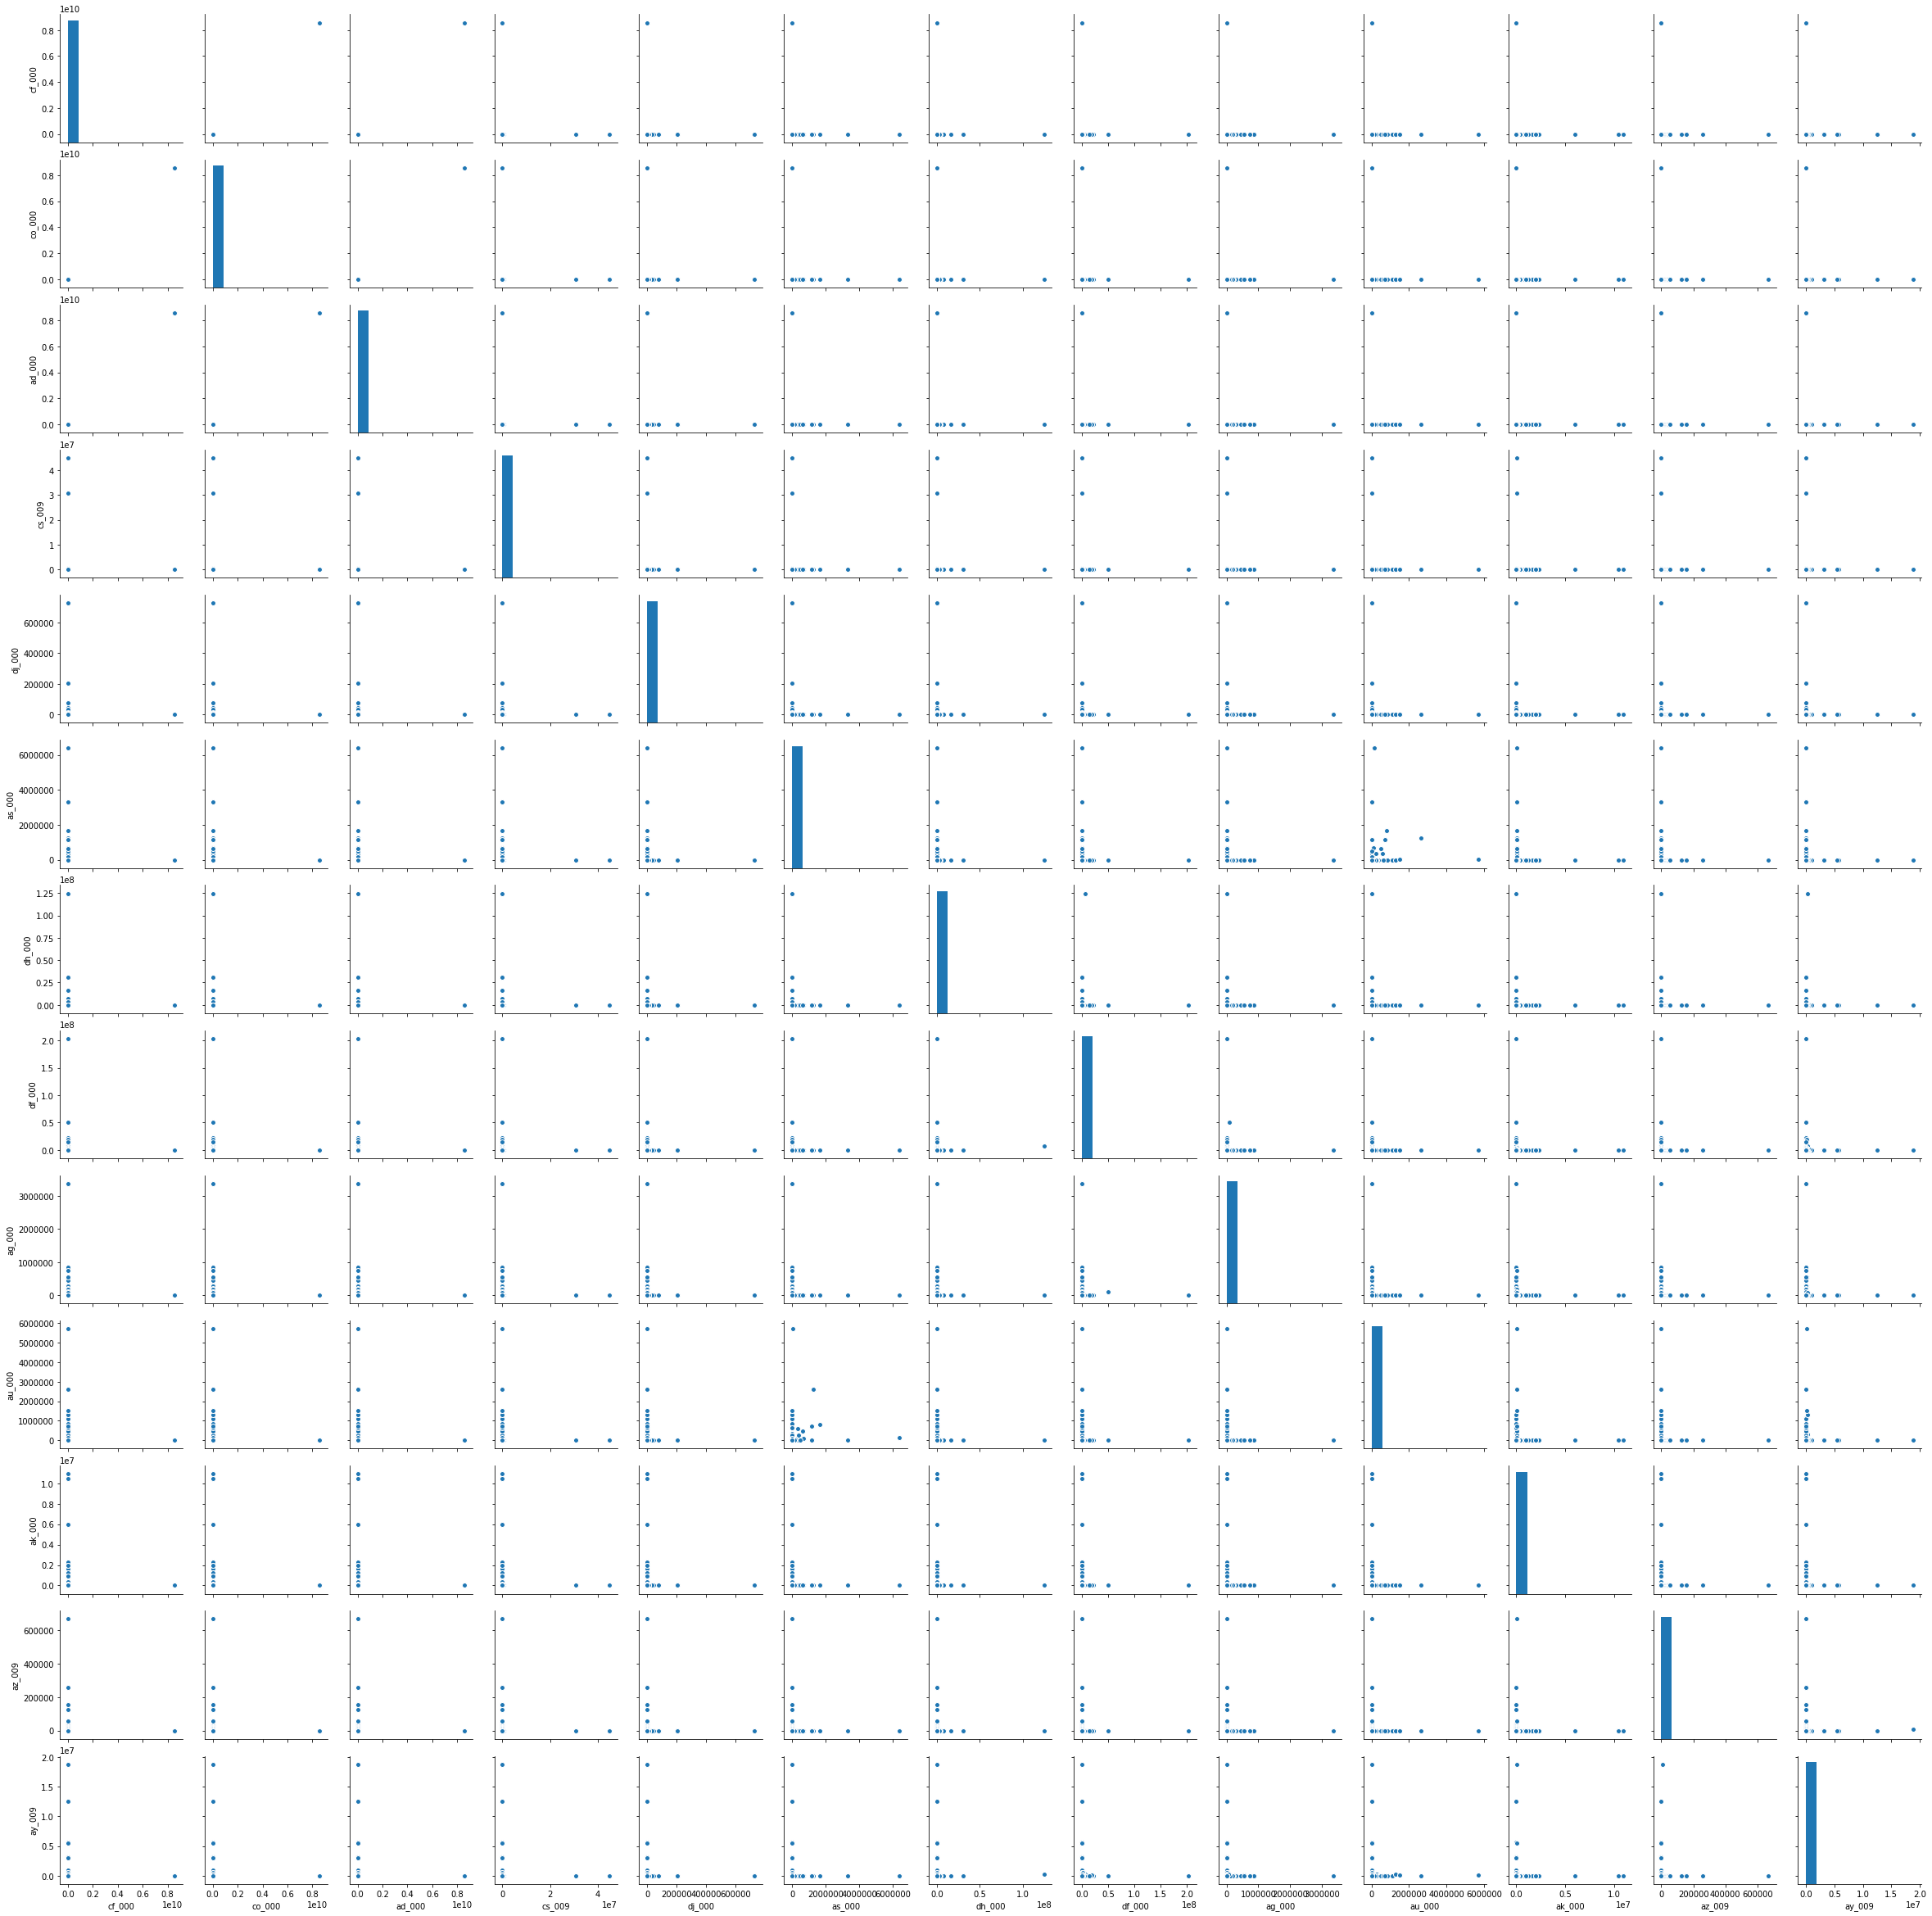

In [2]:
# iv.
n = int(np.sqrt(170))
ncv = cv.nlargest(n, 0)
selected_features = features.iloc[:,ncv.index]
selected_features.columns = column[ncv.index]
# scatter plots
sns.pairplot(selected_features)

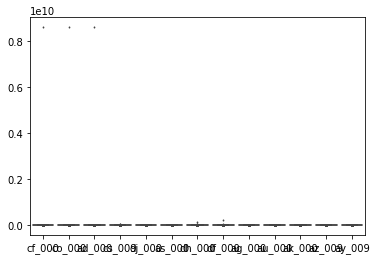

In [3]:
#box plots
sns.boxplot(data=selected_features, orient="v", fliersize=1)
# plt.boxplot(selected_features, showfliers=False)
# plt.show()

In [9]:
# v. Determine the number of positive and negative data. Is this data set imbalanced?
labels = pd.concat([train_label, test_label])
# labels.columns = ['class']
print(labels.value_counts())
print('Negative data is far more than positive data. So this data set is imbalanced.')

neg    74625
pos     1375
Name: class, dtype: int64
Negative data is far more than positive data. So this data set is imbalanced.


# (c)

The out-of-bag-error is smaller than the test error for the random forest model.

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


For training set:
The confusion matrix is:
[[59000     0]
 [   14   986]]
AUC and ROC:
AUC is 0.9999995084745762
The misclassification rate is: 0.00023333333333330764


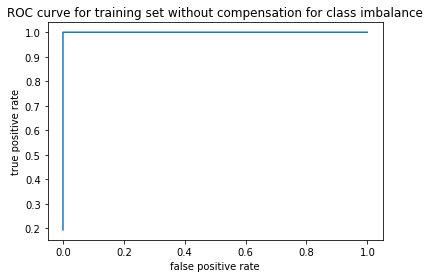

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics

clf = RandomForestClassifier(random_state=0, n_estimators=20, oob_score=True).fit(train_data, train_label)

train_r = clf.predict(train_data)
test_r = clf.predict(test_data)

train_p = clf.predict_proba(train_data)
test_p = clf.predict_proba(test_data)

print('For training set:')
print('The confusion matrix is:')
print(metrics.confusion_matrix(train_label, train_r))

print('AUC and ROC:')
fpr, tpr, thresholds = metrics.roc_curve(train_label, train_p[:,1], pos_label='pos')
print('AUC is',metrics.auc(fpr,tpr))

plt.title('ROC curve for training set without compensation for class imbalance')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fpr,tpr)

print("The misclassification rate is:", 1-clf.score(train_data,train_label))

For test set:
The confusion matrix is:
[[15607    18]
 [  112   263]]
AUC and ROC:
AUC is 0.978878208
The misclassification rate is: 0.008125000000000049
Out of bag error is:  0.007583333333333386


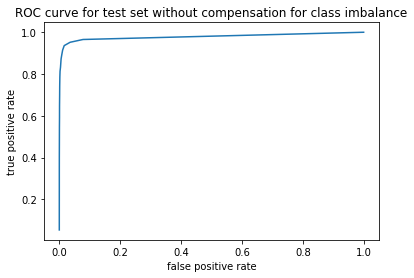

In [22]:
print('For test set:')
print('The confusion matrix is:')
print(metrics.confusion_matrix(test_label, test_r))

print("AUC and ROC:")
fpr, tpr, thresholds = metrics.roc_curve(test_label, test_p[:,1], pos_label='pos')
print('AUC is',metrics.auc(fpr,tpr))

plt.title('ROC curve for test set without compensation for class imbalance')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fpr,tpr)

print('The misclassification rate is:', 1-clf.score(test_data,test_label))
print('Out of bag error is: ',1-clf.oob_score_)

# (d)
In RandomForestClassifier of sklearn, there is a parameter ‘class_weight’ . It can be set to “balanced” to deal with class imbalance problem. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
The train error here is larger than (c), and the test error is larger than (c), too.

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


For training set:
The confusion matrix is:
[[59000     0]
 [   19   981]]
AUC and ROC:
AUC is 0.9999997033898306
The misclassification rate is: 0.0003166666666666318


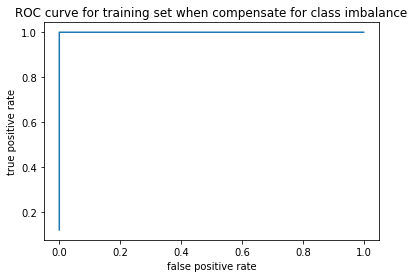

In [19]:
# The “balanced” mode uses the values of y to automatically adjust weights inversely 
# proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
clf = RandomForestClassifier(random_state=0, n_estimators=20, oob_score=True, class_weight='balanced').fit(train_data, train_label)

train_r = clf.predict(train_data)
test_r = clf.predict(test_data)

train_p = clf.predict_proba(train_data)
test_p = clf.predict_proba(test_data)

print('For training set:')
print('The confusion matrix is:')
print(metrics.confusion_matrix(train_label, train_r))

print('AUC and ROC:')
fpr, tpr, thresholds = metrics.roc_curve(train_label, train_p[:,1], pos_label='pos')
print('AUC is',metrics.auc(fpr,tpr))

plt.title('ROC curve for training set with compensation for class imbalance')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fpr,tpr)

print("The misclassification rate is:", 1-clf.score(train_data,train_label))

For test set:
The confusion matrix is:
[[15613    12]
 [  174   201]]
AUC and ROC:
AUC is 0.9714094933333334
The misclassification rate is: 0.011624999999999996
Out of bag error is:  0.009466666666666623


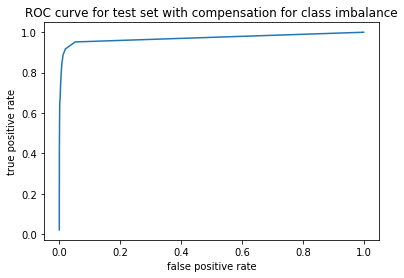

In [20]:
print('For test set:')
print('The confusion matrix is:')
print(metrics.confusion_matrix(test_label, test_r))

print("AUC and ROC:")
fpr, tpr, thresholds = metrics.roc_curve(test_label, test_p[:,1], pos_label='pos')
print('AUC is',metrics.auc(fpr,tpr))

plt.title('ROC curve for test set with compensation for class imbalance')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fpr,tpr)

print('The misclassification rate is:', 1-clf.score(test_data,test_label))
print('Out of bag error is: ',1-clf.oob_score_)

# (e) Model Trees

In [23]:
from imblearn.over_sampling import SMOTE
from arff2pandas import a2p
train_set = pd.concat([train_data, train_label], axis=1)
test_set = pd.concat([test_data, test_label], axis=1)
name=[]
for x in range(170):
    name.append('power%s@NUMERIC' % x)
name1 = name+['label@{neg,pos}']

train_set.columns = name1
test_set.columns = name1

with open('train_data.arff','w') as f:
    a2p.dump(train_set, f)
with open('test_data.arff','w') as f:
    a2p.dump(test_set, f)

sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_sample(train_data, train_label)

X_res=pd.DataFrame(X_res, columns=name)
y_res=pd.DataFrame(y_res, columns=['label@{neg,pos}'])
sm_data=pd.concat([X_res,y_res], axis=1)
with open('SMOTE_train_data.arff','w') as f:
    a2p.dump(sm_data,f)

In [1]:
import weka.core.jvm as jvm
from weka.classifiers import Classifier
from weka.classifiers import Evaluation
from weka.datagenerators import DataGenerator
from weka.core.converters import Loader, Saver
from weka.core.classes import Random

jvm.stop()
jvm.start(system_cp=True, packages=True)

cls = Classifier(classname='weka.classifiers.trees.LMT', options=['-I' ,'1'])
loader = Loader(classname='weka.core.converters.ArffLoader')
data = loader.load_file('train_data.arff')
data.class_is_last()
test_data = loader.load_file('test_data.arff')
test_data.class_is_last()

test_pred = []
test_prob = []

print('start build')
cls.build_classifier(data)
print('end build')

train_pred = []
train_prob = []

train_label = []
test_label = []
for i in data:
    train_pred.append(cls.classify_instance(i))
    train_prob.append(cls.distribution_for_instance(i))
    if list(i)[-1] == 'neg':
        train_label.append(0)
    else:
        train_label.append(1)
for i in test_data:
    test_pred.append(cls.classify_instance(i))
    test_prob.append(cls.distribution_for_instance(i))
    if list(i)[-1] == 'neg':
        test_label.append(0)
    else:
        test_label.append(1)

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Adding system classpath
DEBUG:weka.core.jvm:Classpath=['c:\\users\\ying\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'c:\\users\\ying\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'c:\\users\\ying\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\javabridge\\jars\\cpython.jar', 'c:\\users\\ying\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'c:\\users\\ying\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled
DEBUG:javabridge.jutil:Creating JVM object
DEBUG:javabridge.jutil:Signalling caller


start build
end build


# 5-fold cross-validation
The error of trained model is larger than the test error

In [29]:
cls1 = Classifier(classname='weka.classifiers.trees.LMT', options=['-I' ,'1'])
evaluation = Evaluation(data)
evaluation.crossvalidate_model(cls1, data, 5, Random(42))
evaluation.summary()

'\nCorrectly Classified Instances       59470               99.1167 %\nIncorrectly Classified Instances       530                0.8833 %\nKappa statistic                          0.7031\nMean absolute error                      0.0181\nRoot mean squared error                  0.0847\nRelative absolute error                 55.1313 %\nRoot relative squared error             66.1502 %\nTotal Number of Instances            60000     \n'

For training set:
The confusion matrix is:
[[58908    92]
 [  258   742]]
AUC and ROC:
AUC is 0.9866893728813559
The misclassification rate is: 0.005833333333333357


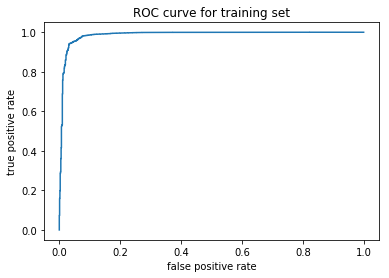

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
train_prob = np.array(train_prob)

print('For training set:')
print('The confusion matrix is:')
print(metrics.confusion_matrix(train_label, train_pred))

print('AUC and ROC:')
fpr, tpr, thresholds = metrics.roc_curve(train_label, train_prob[:,0], pos_label=0)
print('AUC is', metrics.auc(fpr,tpr))

plt.title('ROC curve for training set')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fpr,tpr)

print("The misclassification rate is:", 1-accuracy_score(train_label, train_pred))

For test set:
The confusion matrix is:
[[15596    29]
 [  127   248]]
AUC and ROC:
AUC is 0.9917095253333335
The misclassification rate is: 0.009750000000000036


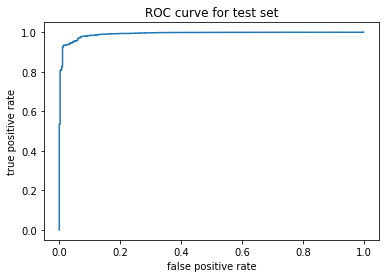

In [7]:
test_prob = np.array(test_prob)
print('For test set:')

print('The confusion matrix is:')
print(metrics.confusion_matrix(test_label, test_pred))

print('AUC and ROC:')
fpr, tpr, thresholds = metrics.roc_curve(test_label, test_prob[:,0], pos_label=0)
print('AUC is',metrics.auc(fpr,tpr))

plt.title('ROC curve for test set')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fpr,tpr)

print('The misclassification rate is:', 1-accuracy_score(test_label, test_pred))

# (f) Use SMOTE to compensate for class imbalance
The right way to use cross validation here: We should apply SMOTE to k-1 fold training data in each step of k-fold cross validation. Then calculate the test error rate by average.

Compared to uncompensated case, SMOTE has a little bit higher error of trained model. Actually, they are almost the same.
The test error in training set of SMOTE is much smaller than that of uncompensated case. But the test error in test set of SMOTE is larger than that of uncompensated case. Maybe due to overfit.

In [8]:
cls_sm = Classifier(classname='weka.classifiers.trees.LMT', options=['-I' ,'1'])
loader = Loader(classname='weka.core.converters.ArffLoader')
sm_data = loader.load_file('SMOTE_train_data.arff')
sm_data.class_is_last()

# 5-fold cross validation

In [34]:
evaluation1 = Evaluation(sm_data)
evaluation1.crossvalidate_model(cls_sm, data, 5, Random(42))
print('Summary of 5-fold cross validation:')
evaluation1.summary()

Summary of 5-fold cross validation:


'\nCorrectly Classified Instances       116952               99.1119 %\nIncorrectly Classified Instances       1048                0.8881 %\nKappa statistic                          0.9802\nMean absolute error                      0.0151\nRoot mean squared error                  0.0895\nRelative absolute error                 2.8746 %\nRoot relative squared error             17.5057 %\nTotal Number of Instances            118000     \n'